In [48]:
import cv2
import numpy as np
from skimage import transform
from IPython.display import display
from skimage import transform, exposure
from PIL import Image, ImageOps,ImageEnhance
import thinplate.hybrid as tps
import blend_modes
from PIL import ImageEnhance, Image
import matplotlib.pyplot as plt
import blend_modes
import wand.image
pil_imshow = lambda x: display(Image.fromarray(x.astype(np.uint8)))

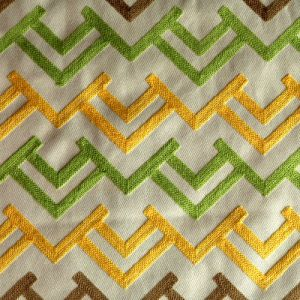

(300, 300, 3)


In [53]:
fabric = cv2.imread('dataset/fabic3.jpg')
fabric_img = cv2.cvtColor(fabric, cv2.COLOR_BGR2RGB)
pil_imshow(fabric_img)
print(fabric_img.shape)

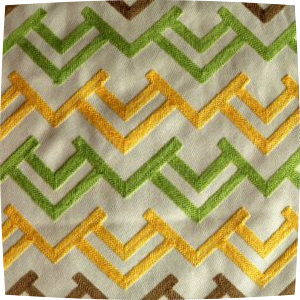

(300, 300, 4)


In [55]:
with wand.image.Image.from_array(fabric_img) as img:
    img.virtual_pixel = 'transparent'
    img.distort('barrel', (0, 0., 0.10, 0.9))
    fabric_com = np.asarray(img)
pil_imshow(fabric_com)
print(fabric_com.shape)

In [56]:
def create_pts_for_tps(cords,res):
    # Ignore (Used in Bedsheets)
    slcs = {40:(0,None)}
    snew, dnew = [], []
    
    for idx,i in enumerate(cords):
        if len(i) > 2:
            s,e = slcs[idx] if idx in slcs else (0,None)
            snew.append(np.linspace(i[0], i[1], i[2])[s:e]) # generates new pts between the 2 end points
            dnew.append(np.linspace(i[3], i[4], i[2])[s:e])
        else:
            snew.append(np.array([i[0]]))
            dnew.append(np.array([i[1]]))

    # Src = fabric , dst = base Img
    c_src = np.vstack(snew).astype(np.float32)
    c_dst = np.vstack(dnew).astype(np.float32)
    # Check to see if they are same num of pts in src and dst
    assert len(c_src) == len(c_dst), f"{len(c_src)}, {len(c_dst)}"

    _, idxs = np.unique(c_dst.astype(int), return_index=True, axis=0)
    c_src = c_src[idxs]/1.
    c_dst = c_dst[idxs]/np.array(res).astype(np.float32) # divide by template size to make btw 0 1

    return c_src,c_dst


def Thin_plate_splines(c_src,c_dst,output_size, fabric):
    '''
    Function to generated grid based on thin plate splines.
    Saves grid and generates fabric segment for blending
    '''
    
    # We first calculate theta for our grid generation
    theta = tps.tps_theta_from_points(c_src, c_dst, reduced=False)
    # Genertaes grid x,y, values  where to map
    grid = tps.tps_grid(theta, c_dst, out_size)     # slowest step
    # Extract x and y values from grid to map it to org img
    mapx, mapy = tps.tps_grid_to_remap(grid, fabric.shape)

    # We create the fabric 
    tpw = cv2.remap(fabric, mapx, mapy, cv2.INTER_CUBIC)
    cv2.imwrite('fabric_after_tps.jpg', tpw)  # Change Segment Mask Name 
    print("Generated Fabric Segment Image")
    print()
    pil_imshow(tpw)
    return cv2.cvtColor(tpw, cv2.COLOR_BGR2RGB)

Generated Fabric Segment Image



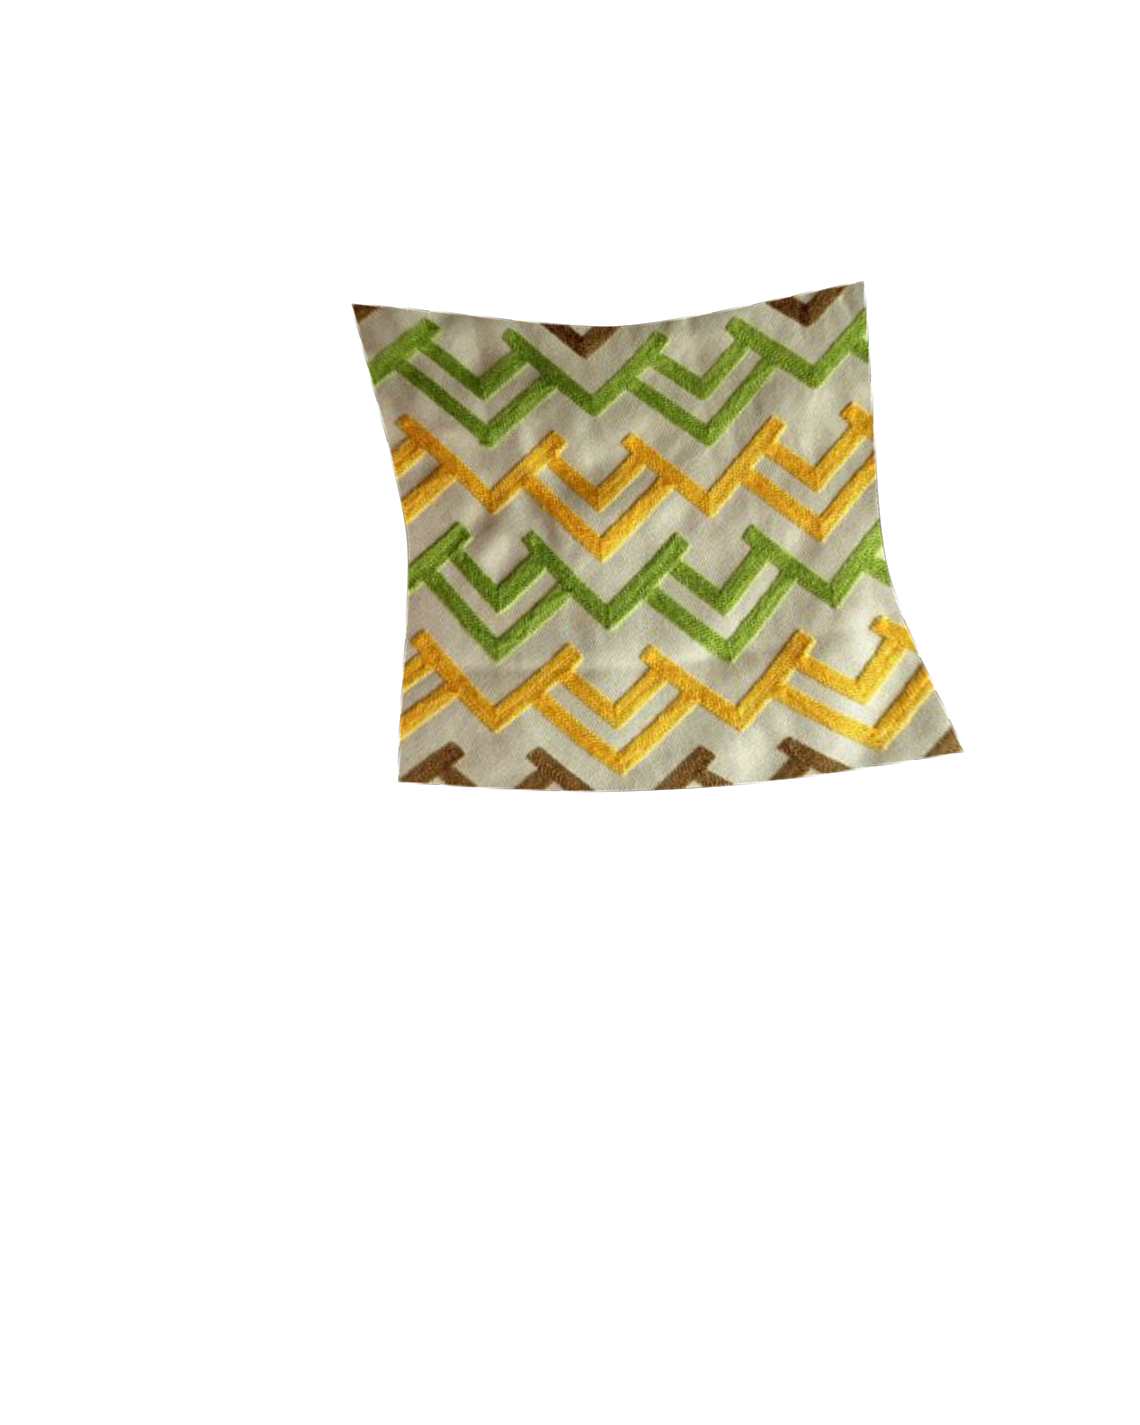

In [57]:
# Cords paste mask to our template (Fabric to template cords)

# Cordinates stucture : [[Top Left of Fabric], [Top Right of Fabric], (Number of Points to be Generated between these endpoints), [Top Left of Base Img], [Top Right of Base Img]]

cords =[
        [[0.0,0.0], [340, 295]],
        [[1.0,0.0], [874, 271]],
        [[0.0,1.0], [389, 791]],
        [[1.0,1.0], [981, 759]],
        [[0.5,0.0], [614,327]],
        [[0.0,0.5], [408,540]],
        [[1.0,0.6], [890,572]],
]

# Parameters to adjust 
out_size = (1425,1140,3) # Size of Template IMG
res = [1140., 1425.] # w*h
# grid_name = 'left_mask.npy' 

# Extract Source and Destination points
c_src ,c_dst = create_pts_for_tps(cords,res)
# Generated Grid and Segment
grid = Thin_plate_splines(c_src,c_dst,out_size, fabric_com)
# Saves Grid File (Important)
# np.save(grid_name, grid)  # Change Mask name 